In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import os
from matplotlib import pyplot as plot
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(f'Device: {torch.cuda.get_device_name(device)}')

cuda:0
Device: Tesla T4


In [3]:
lrate = 0.001
num_epochs = 5
batch_size = 128
dir_name = os.getcwd()
res_names = []
res_valuse = []
loss_function = torch.nn.CrossEntropyLoss()
cftransforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
def get_accuracy(model, data_loader):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels, images = labels.to(device), images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

In [10]:
class Worker():
    def __init__(self, name_of_model, weights_of_model, transforms):
        self.name = name_of_model
        self.weights = weights_of_model
        train_dataset = torchvision.datasets.CIFAR10( root = dir_name, train = True,
        download = True, transform = transforms ) # fix
        test_dataset = torchvision.datasets.CIFAR10( root = dir_name, train = False,
        download = True, transform = transforms ) # fix
        self.train_data_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size = batch_size, shuffle = True )
        self.test_data_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size = batch_size, shuffle = False )
        self.model = getattr(torchvision.models, name_of_model)(weights=weights_of_model)

    def train_and_test(self, optimizer, loss_function):
        self.model = self.model.to(device)
        tg0 = time.time()
        for epoch in range(num_epochs):
            t0 = time.time()
            for images, labels in self.train_data_loader:
                images = images.to(device)
                labels = labels.to(device)
                new_m = self.model(images)
                loss = loss_function(new_m, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            t1 = time.time()
            print(f'Epoch[{epoch}]: acc = {get_accuracy(self.model, self.train_data_loader)}, time = {t1 - t0}')
        tg1 = time.time()
        print("Time: ", {tg1-tg0});
        acc = get_accuracy(self.model, self.test_data_loader)
        res_names.append(self.name)
        res_valuse.append(acc)
        print('Test acc: {}'.format(acc))




In [11]:
def start_one(wrk):
    print(wrk.name)
    for prm_of_model in wrk.model.parameters():
        prm_of_model.requires_grad = False
    if wrk.name == "resnet18" or wrk.name == "googlenet" or wrk.name == "resnet50":
        features_count = wrk.model.fc.in_features
        wrk.model.fc = torch.nn.Linear(features_count, 10)
        optimizer = torch.optim.Adam(wrk.model.fc.parameters(), lr=lrate)
        wrk.train_and_test( optimizer, loss_function )
    if wrk.name == "mobilenet_v3_small":
        features_count = wrk.model.classifier[-1].in_features
        wrk.model.classifier[-1] = torch.nn.Linear(features_count, 10)
        optimizer = torch.optim.Adam(wrk.model.classifier[-1].parameters(), lr=lrate)
        wrk.train_and_test( optimizer, loss_function )
    if wrk.name == "vit_b_16":
        features_count = wrk.model.heads[0].in_features
        wrk.model.heads = torch.nn.Linear(features_count, 10)
        print(features_count)
        optimizer = torch.optim.Adam(wrk.model.heads.parameters(), lr=lrate)
        wrk.train_and_test( optimizer, loss_function )

    print(wrk.model)
def start_two(wrk):
    print(wrk.name)
    for prm_of_model in wrk.model.parameters():
        prm_of_model.requires_grad = False
    if wrk.name == "resnet18" or wrk.name == "resnet50":
        features_count = wrk.model.fc.in_features
        wrk.model.fc = torch.nn.Sequential(
        torch.nn.Linear(features_count, features_count//2),
        torch.nn.ReLU(),
        torch.nn.Linear(features_count//2, 10),
        )
        print(features_count)
        optimizer = torch.optim.Adam(wrk.model.fc.parameters(), lr=lrate)
        wrk.train_and_test( optimizer, loss_function )
    if wrk.name == "mobilenet_v3_small":
        features_count = wrk.model.classifier[-1].in_features
        wrk.model.classifier[-1] = torch.nn.Sequential(
        torch.nn.Linear(features_count, features_count//2),
        torch.nn.ReLU(),
        torch.nn.Linear(features_count//2, 10),
        )
        print(features_count)
        optimizer = torch.optim.Adam(wrk.model.fc.parameters(), lr=lrate)
        wrk.train_and_test( optimizer, loss_function )
    if wrk.name == "vit_b_16":
        features_count = wrk.model.heads[0].in_features
        wrk.model.heads = torch.nn.Sequential(
        torch.nn.Linear(features_count, features_count//2),
        torch.nn.ReLU(),
        torch.nn.Linear(features_count//2, 10),
        )
        print(features_count)
        optimizer = torch.optim.Adam(wrk.model.heads.parameters(), lr=lrate)
        wrk.train_and_test( optimizer, loss_function )
    print(wrk.model)
def start_three(wrk):
    print(wrk.name)
    optimizer = torch.optim.Adam(wrk.model.parameters(), lr=lrate)
    wrk.train_and_test( optimizer, loss_function )
    print(wrk.model)



In [ ]:
worker_resnet18 = Worker("resnet18", "ResNet18_Weights.IMAGENET1K_V1", torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms())
start_two(worker_resnet18)
worker_resnet18_sec = Worker("resnet18", "ResNet18_Weights.IMAGENET1K_V1", torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms())
start_one(worker_resnet18_sec)
print(res_valuse)
print(res_names[0]+"_one")
print(res_names[1]+"_deep")




Files already downloaded and verified
Files already downloaded and verified
resnet18
512
Epoch[0]: acc = 0.7708199620246887, time = 138.37115120887756
Epoch[1]: acc = 0.7821199893951416, time = 138.09055924415588
Epoch[2]: acc = 0.7829399704933167, time = 134.9507396221161
Epoch[3]: acc = 0.7817599773406982, time = 136.34877252578735
Epoch[4]: acc = 0.7989599704742432, time = 140.91054368019104
Time:  {1370.4095239639282}
Test acc: 0.7795999646186829
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu)

In [ ]:
worker_mibilenet = Worker("mobilenet_v3_small", "MobileNet_V3_Small_Weights.IMAGENET1K_V1", torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms())
start_one(worker_mibilenet)
worker_mibilenet_sec = Worker("mobilenet_v3_small", "MobileNet_V3_Small_Weights.IMAGENET1K_V1", cftransforms)
start_three(worker_mibilenet_sec)
print(res_valuse)
print(res_names[2]+"_one")
print(res_names[3]+"_full")

Files already downloaded and verified
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 63.6MB/s]


mobilenet_v3_small
Epoch[0]: acc = 0.8077999949455261, time = 137.06814861297607
Epoch[1]: acc = 0.8209199905395508, time = 139.84806442260742
Epoch[2]: acc = 0.8269000053405762, time = 139.56226706504822
Epoch[3]: acc = 0.8294199705123901, time = 136.40933632850647
Epoch[4]: acc = 0.8319999575614929, time = 137.88065886497498
Time:  {1376.224886417389}
Test acc: 0.8111000061035156
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
   

In [ ]:
worker_googlenet = Worker("googlenet","GoogLeNet_Weights.IMAGENET1K_V1",torchvision.models.GoogLeNet_Weights.IMAGENET1K_V1.transforms())
start_one(worker_googlenet)
worker_googlenet_sec = Worker("googlenet", "GoogLeNet_Weights.IMAGENET1K_V1", cftransforms)
start_three(worker_googlenet_sec)
print(res_valuse)
print(res_names[4]+"_one")
print(res_names[5]+"_full")

Files already downloaded and verified
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 90.4MB/s]


googlenet
Epoch[0]: acc = 0.7420799732208252, time = 140.03120279312134
Epoch[1]: acc = 0.751039981842041, time = 137.8761785030365
Epoch[2]: acc = 0.7638999819755554, time = 142.07433891296387
Epoch[3]: acc = 0.7675399780273438, time = 138.9849669933319
Epoch[4]: acc = 0.7731599807739258, time = 138.4294171333313
Time:  {1392.5280103683472}
Test acc: 0.7547999620437622
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): Batc

In [ ]:
worker_resnet50 = Worker("resnet50", "ResNet50_Weights.IMAGENET1K_V2", torchvision.models.ResNet50_Weights.IMAGENET1K_V2.transforms())
start_one(worker_resnet50)
worker_resnet50_sec = Worker("resnet50", "ResNet50_Weights.IMAGENET1K_V2", torchvision.models.ResNet50_Weights.IMAGENET1K_V2.transforms())
start_two(worker_resnet50_sec)
print(res_valuse)
print(res_names[2]+"_one")
print(res_names[3]+"_deep")


Files already downloaded and verified
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]


resnet50
Epoch[0]: acc = 0.7817800045013428, time = 167.220764875412
Epoch[1]: acc = 0.8096199631690979, time = 167.70978307724
Epoch[2]: acc = 0.8217200040817261, time = 168.1025915145874
Epoch[3]: acc = 0.8294599652290344, time = 169.13328409194946
Epoch[4]: acc = 0.8393200039863586, time = 167.88271689414978
Time:  {1681.0802376270294}
Test acc: 0.8071999549865723
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

<BarContainer object of 8 artists>

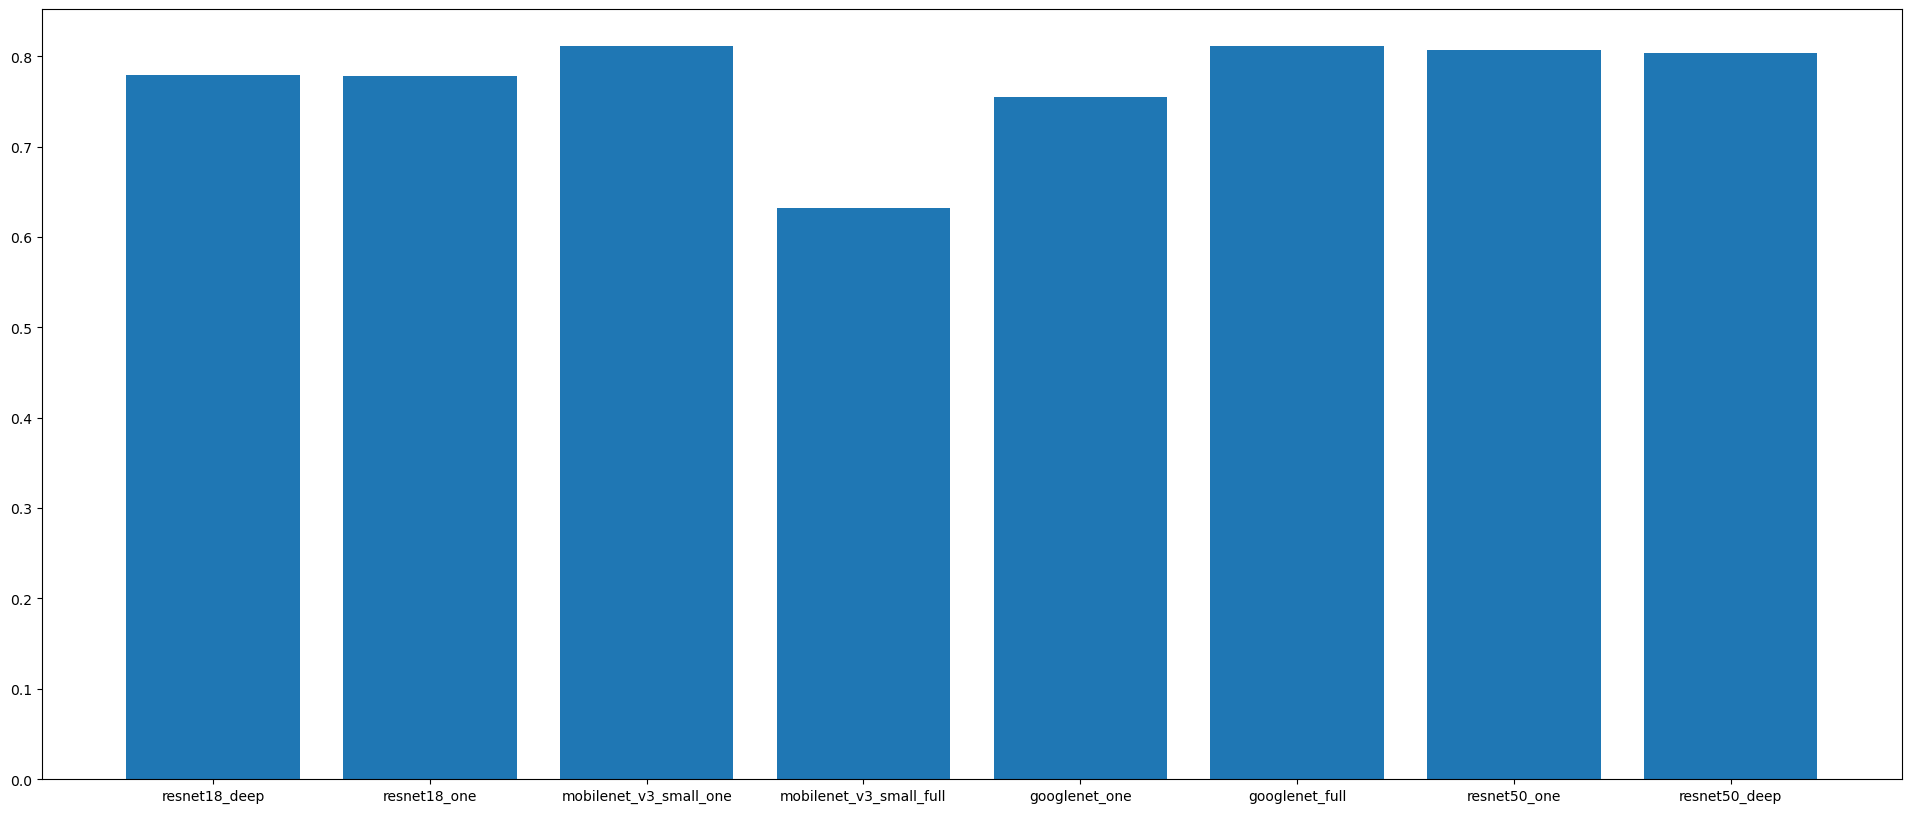

In [ ]:
from matplotlib import pyplot as plot
result_names = ["resnet18_deep", "resnet18_one","mobilenet_v3_small_one","mobilenet_v3_small_full", "googlenet_one", "googlenet_full","resnet50_one","resnet50_deep" ]
result_values = [0.7796, 0.7782, 0.8111, 0.6318, 0.7548, 0.8115, 0.8072, 0.8037]
plot.figure(figsize = (24, 10))
plot.bar(result_names, result_values)


In [12]:
worker_vit = Worker("vit_b_16", "ViT_B_16_Weights.DEFAULT", torchvision.models.ViT_B_16_Weights.DEFAULT.transforms())
start_two(worker_vit)


100%|██████████| 170498071/170498071 [00:12<00:00, 13278006.53it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 65.5MB/s]


vit_b_16
768
Epoch[0]: acc = 0.9603999853134155, time = 592.4060637950897
Epoch[1]: acc = 0.9706199765205383, time = 592.0329320430756
Epoch[2]: acc = 0.9794999957084656, time = 591.5894939899445
Epoch[3]: acc = 0.9865599870681763, time = 591.6757760047913
Epoch[4]: acc = 0.987339973449707, time = 590.2111518383026
Time:  {5924.538775444031}
Test acc: 0.9505999684333801
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768

In [14]:
worker_vit_sec = Worker("vit_b_16", "ViT_B_16_Weights.DEFAULT", torchvision.models.ViT_B_16_Weights.DEFAULT.transforms())
start_one(worker_vit_sec)

Files already downloaded and verified
Files already downloaded and verified
vit_b_16
768
Epoch[0]: acc = 0.9480199813842773, time = 590.2733819484711
Epoch[1]: acc = 0.9548199772834778, time = 588.7941012382507
Epoch[2]: acc = 0.9598599672317505, time = 590.2820425033569
Epoch[3]: acc = 0.9627400040626526, time = 591.1582546234131
Epoch[4]: acc = 0.9645799994468689, time = 590.2547073364258
Time:  {5911.526317358017}
Test acc: 0.9490000009536743
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwis

<BarContainer object of 10 artists>

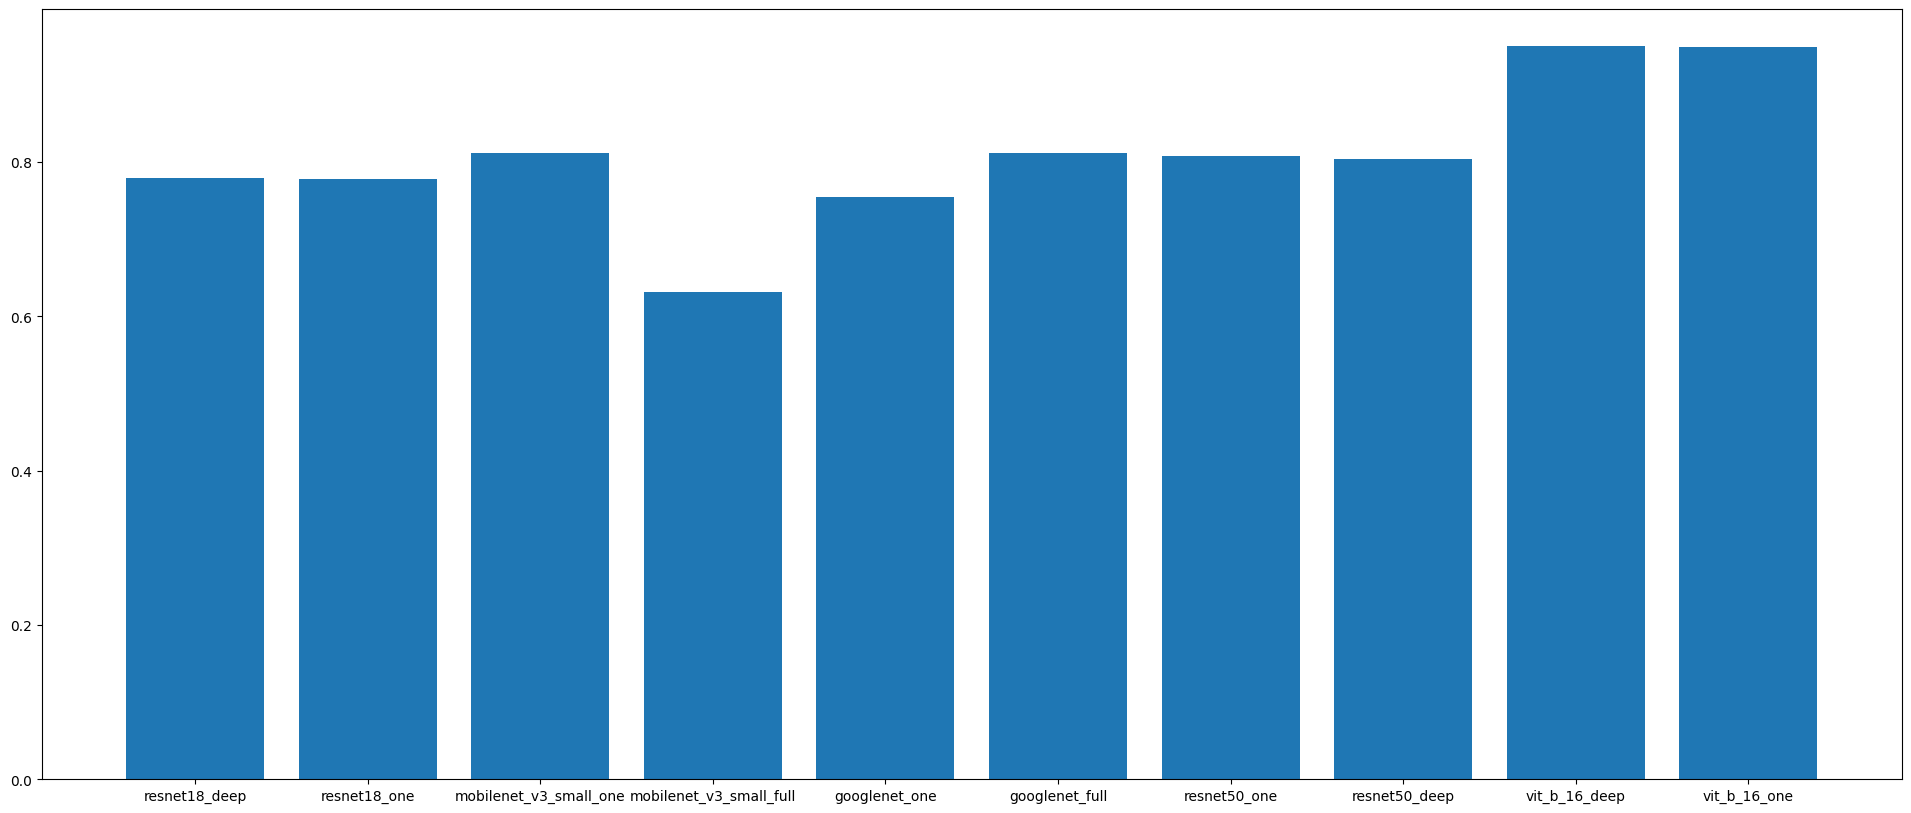

In [15]:
from matplotlib import pyplot as plot
result_names = ["resnet18_deep", "resnet18_one","mobilenet_v3_small_one","mobilenet_v3_small_full", "googlenet_one", "googlenet_full", "resnet50_one", "resnet50_deep", "vit_b_16_deep", "vit_b_16_one" ]
result_values = [0.7796, 0.7782, 0.8111, 0.6318, 0.7548, 0.8115, 0.8072, 0.8037, 0.95059, 0.9490]
plot.figure(figsize = (24, 10))
plot.bar(result_names, result_values)